# INF8111 - Fouille de données


## TP2 Automne 2019 - Détection de discours d'incitation à la haine

##### Membres de l'équipe:

    - MAINKA Adrien (2046374)
    - BAKKAOUI Mehdi (2038803)
    - METAIS Marianne (2038757)

In [1]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
import words_repeated_char
import sys
import nltk
import pickle
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## 1. importation des données

In [33]:
file = open("data/preprocess_balanced.pkl",'rb')
preprocessed = pickle.load(file) #C'est une database balanced i.e qu'il y autant d'exemples pour chacune des classes.
file.close()

In [8]:
preprocessed.head()

,tweet,label
0,"[yall, nigga, stop, dick, riding, ..., you, ai...",1
1,"[i, put, my, iphone, in, my, pocket, with, scr...",0
2,"[wait, until, you, learn, that, the, u, rescue...",0
3,"[we, 're, dead, ., we, 're, all, dead, ., well...",0
4,"[what, could, USER, have, in, store, ?, follow...",3


## 2. Jeu de données

In [22]:
from sklearn.model_selection import train_test_split

X = preprocessed['tweet']
y = preprocessed['label']

train_valid_X, test_X, train_valid_Y, test_Y = train_test_split(X, y, test_size=0.15, random_state=12)

train_X, valid_X, train_Y, valid_Y = train_test_split(train_valid_X, train_valid_Y, test_size=0.18, random_state=12)

print("Length of training set : ", len(train_X))
print("Length of validation set : ", len(valid_X))
print("Length of test set : ", len(test_X))

Length of training set :  10560
Length of validation set :  2319
Length of test set :  2273


## 3. Stemming

In [23]:
from nltk.stem.snowball import SnowballStemmer


class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)

    def stem(self, tweet):
        """
        tweet: a list of string
        """
        # Have to return the stemmed tweet
        return list(map(self.stemmer.stem , tweet))

In [24]:
s=Stemmer()
X = list(map(s.stem, X))

## 4. Classification

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score


def train_evaluate(classifier, training_X, training_Y, validation_X, validation_Y, bowObj):
    """
    classifier: model used (LogisticRegression...)
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset
    bowObj: Bag-of-word object
    
    :return: the classifier and its accuracy in the training and validation dataset.
    """

    training_rep = bowObj.fit_transform(training_X)

    classifier.fit(training_rep, training_Y)

    trainAcc = accuracy_score(training_Y, classifier.predict(training_rep))
    validationAcc = accuracy_score(
        validation_Y, classifier.predict(bowObj.transform(validation_X)))

    return classifier, trainAcc, validationAcc

In [26]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def function(token):
    return token

def model_comparison(classifier, nom_classifier):
    """
    classifier: model used (LogisticRegression...)
    nom_classifier: model name
    
    :return: Comparison of the classifier with CountBoW, TF-IDF, unigram and bigram.
    """
    
    trainAcc = []
    validationAcc = []

    # 1.classifier + CountBoW + unigram
    cv = CountVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,1))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, cv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])

    # 2.classifier + CountBoW + unigram + bigram
    cv = CountVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,2))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, cv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])

    # 3.classifier + TF-IDF + unigram
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,1))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, tv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])

    # 4.classifier + TF-IDF + unigram + bigram
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,2))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, tv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])
    
    # Graphe de comparaison des différents modèles
    
    r=np.arange(len(trainAcc))
    
    TypeAcc = ["Training", "Validation"]
    models_names = ['CountBoW \nunigram', 'CountBoW \nunigram \nbigram', 
     'TF-IDF \nunigram', 'TF-IDF \nunigram \nbigram']
    bar_width = 0.4

    plt.bar(r, trainAcc,bar_width)
    plt.bar(r+bar_width, validationAcc,bar_width)
    plt.xticks(r+bar_width/2, models_names, rotation=0)

    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')

    plt.title(nom_classifier)

    plt.legend(TypeAcc)

    for i in range(len(trainAcc)):
        plt.text(x = r[i]-bar_width/2 , y = trainAcc[i]+0.01, s = '%.4f' % trainAcc[i])
        plt.text(x = r[i]+bar_width/2 , y = validationAcc[i]+0.01, s = '%.4f' % validationAcc[i])

    plt.ylim(.5, 1.2)
    plt.show()

### 5.1 Modèles linéaires

#### 5.1.1 Régression logistique

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


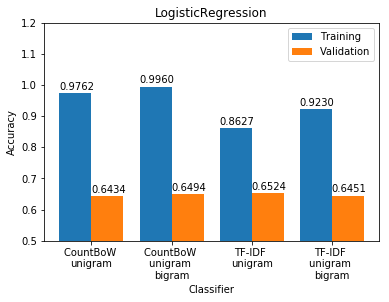

In [27]:
from sklearn.linear_model import LogisticRegression

model_comparison(LogisticRegression(),'LogisticRegression')

#### 5.1.2 Stochastic Gradient Descent

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


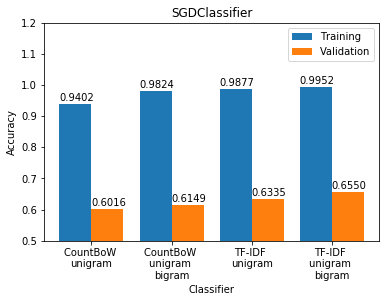

In [28]:
from sklearn.linear_model import SGDClassifier

model_comparison(SGDClassifier(),'SGDClassifier')

#### 5.1.3 Perceptron

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


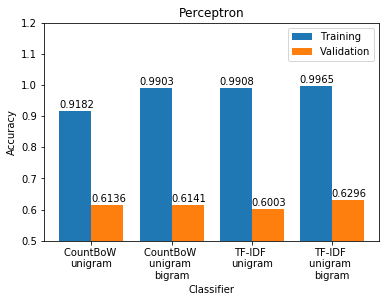

In [29]:
from sklearn.linear_model import Perceptron

model_comparison(Perceptron(),'Perceptron')

#### 5.1.4 PassiveAggressiveClassifier

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


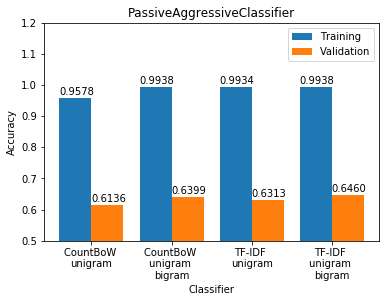

In [30]:
from sklearn.linear_model import PassiveAggressiveClassifier

model_comparison(PassiveAggressiveClassifier(),'PassiveAggressiveClassifier')

### 5.2 Support Vector Machines 

#### 5.2.1  Linear Support Vector Classification

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


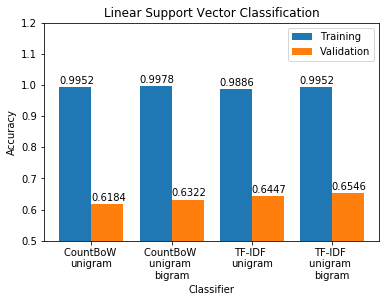

In [31]:
from sklearn.svm import LinearSVC 

model_comparison(LinearSVC(),'Linear Support Vector Classification')

### 5.3 Decision Trees

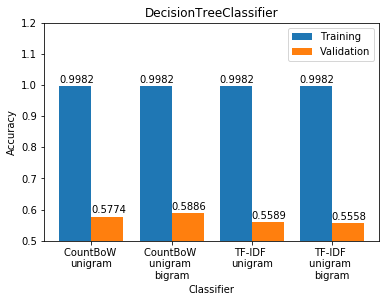

In [32]:
from sklearn.tree import DecisionTreeClassifier

model_comparison(DecisionTreeClassifier(),'DecisionTreeClassifier')